In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dnaobj.tbp_se import TBP_SE as AlgI
from dnaobj.eiip import Eiip
from dnaobj.snr_se import SNR_SE as AlgII
from dnaobj.qpsk import Qpsk
from dnaobj.mem import Mem
from dnaobj.spectralanalysis import SpectralAnalysis
from dnaobj.voss import Voss
from utils.read_files import read_fasta


In [2]:
# seq = read_fasta('./database-seq/F56F11_4a_coding.fasta')
seq = read_fasta('./database-seq/YOR215C.fasta')
# seq = read_fasta('./database-seq/YNL122C.fasta')


558


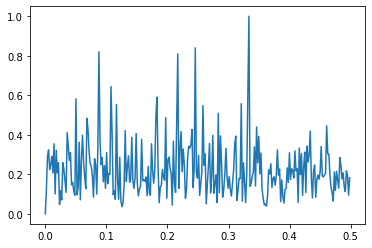

In [3]:
dna = Voss(seq)
dna.fft = SpectralAnalysis(dna).dna_fourier()
dna.freq, dna.energy = SpectralAnalysis(dna).one_sided_energy(dc_value=False, normalized=True)
plt.plot(dna.freq, dna.energy)
print(dna.N)

(2157.6430976430975, 558)

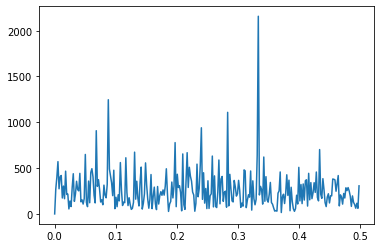

In [4]:
dna = AlgI(seq)
dna.freq, dna.energy = SpectralAnalysis(dna).one_sided_energy(dc_value=False, normalized=False)
plt.plot(dna.freq, dna.energy)
max(dna.energy), dna.N

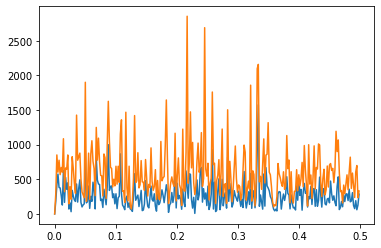

In [5]:
dna = Voss(seq)
mid = dna.N//2

dna.freq = np.fft.fftfreq(dna.N)
if dna.N % 2 == 0:
    dna.freq = dna.freq[:mid]
else:
    dna.freq = dna.freq[:mid+1]

dna.fft = SpectralAnalysis(dna).dna_fourier()
dna.dimension = 1

env_spec = []
for idx in range(len(dna.freq)):
    # k = dna.N // 3
    # k = 137
    k = idx
    Ui = np.array([[dna.fft[0][k], dna.fft[1][k], dna.fft[2][k], dna.fft[3][k]]])
    cov = np.matmul(Ui.conjugate().T,Ui)

    _, eigvec = np.linalg.eigh(cov)
    mapping = eigvec[:,-1]
    # print(mapping)
    dna.label = {"A": mapping[0], "C": mapping[1], "G": mapping[2], "T": mapping[3]}
    dna.signal = dna.mapping(dna.label) 

    dna.freq, dna.energy = SpectralAnalysis(dna).one_sided_energy(dc_value=False, normalized=False)
    # plt.plot(dna.freq, dna.energy)
    # print(max(dna.energy))
    env_spec.append(dna.energy[k])
    # print(dna.energy[k], dna.freq[k])

    # break


plt.figure()
dna = Qpsk(seq)
dna.freq, dna.energy = SpectralAnalysis(dna).one_sided_energy(dc_value=False, normalized=False)
plt.plot(dna.freq, dna.energy)

# plt.figure()
plt.plot(dna.freq, env_spec)

# fig, ax = plt.subplots()
# dna = AlgII(seq)
# dna.freq, dna.energy = SpectralAnalysis(dna).one_sided_energy(dc_value=False, normalized=False)
# ax.plot(dna.freq, dna.energy)
# dna.label

In [6]:
S = env_spec
Pfund = S[np.argmax(S)]
totalNoise = sum(S) - Pfund
r = 10*np.log10(Pfund / totalNoise)

ePX = sum(S)
pX = S/ePX
H = -sum([k*np.log(k) for k in pX if k > 0])

print("The peak of spectral envelope occurs at frequency", dna.freq[np.argmax(env_spec)])

The peak of spectral envelope occurs at frequency 0.2168458781362007


## Matriz de Confusão dos algoritmos

In [7]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix

results_path = r"/home/milena/Documents/dna/dna-spectral-analysis/database-cerevisiae/old_results/results"
print(len(os.listdir(results_path)))

2576


In [8]:
results = dict()
for basename in os.listdir(results_path):
    file = os.path.join(results_path, basename)

    results[basename] = {}
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "M:" in line:
                method = line.split(':')[1].strip()
            if "freq" in line:
                results[basename]["freq"] = np.fromstring(";".join(line.split()[1:]), dtype=float, sep=";")
            if "S" in line:
                results[basename][method] = np.fromstring(";".join(line.split()[1:]), dtype=float, sep=";")
                # print(line)
                # break
        
    
    # break

In [9]:
tp, fp, tn, fn = [0] * 4


for method in ["voss", "eiip", "qpsk", "mem", "alg1", "alg2"]:
    true_class = []
    predict_class = []

    for basename in os.listdir(results_path):
        S = results[basename][method]
        k = np.argmax(S)
        freq = results[basename]["freq"][k]
        
        is_coding = False
        if "intergenic" not in basename:
            is_coding = True
        true_class.append(is_coding)

        is_coding_hat = False
        if freq > 1/3-0.02 and freq < 1/3+0.02:
            is_coding_hat = True
        predict_class.append(is_coding_hat)

    tn, fp, fn, tp = confusion_matrix(true_class, predict_class).ravel()

    print(method, tn, fp, fn, tp)
    print("acc =", (tp + tn) / (tn + fp + fn + tp))
    print("sen =", (tp) / (fn + tp))
    print("spe =", (tn) / (tn + fp), end="\n\n")

voss 1148 40 269 1119
acc = 0.8800465838509317
sen = 0.8061959654178674
spe = 0.9663299663299664

eiip 1075 113 253 1135
acc = 0.8579192546583851
sen = 0.8177233429394812
spe = 0.9048821548821548

qpsk 1126 62 292 1096
acc = 0.8625776397515528
sen = 0.7896253602305475
spe = 0.9478114478114478

mem 1103 85 563 825
acc = 0.7484472049689441
sen = 0.5943804034582133
spe = 0.9284511784511784

alg1 1090 98 149 1239
acc = 0.9041149068322981
sen = 0.8926512968299711
spe = 0.9175084175084175

alg2 1122 66 278 1110
acc = 0.8664596273291926
sen = 0.7997118155619597
spe = 0.9444444444444444



In [10]:
tp, fp, tn, fn = [0] * 4


method1 = "voss"
method2 = "alg1"

true_class = []
predict_class_voss = []
predict_class_alg1 = []

for basename in os.listdir(results_path):
    is_coding = False
    if "intergenic" not in basename:
        is_coding = True
    

        S = results[basename][method1]
        k = np.argmax(S)
        freq_voss = results[basename]["freq"][k]
        is_coding_hat_voss = False
        if freq_voss > 1/3-0.02 and freq_voss < 1/3+0.02:
            is_coding_hat_voss = True
        predict_class_voss.append(is_coding_hat_voss)

        S = results[basename][method2]
        k = np.argmax(S)
        freq_alg1 = results[basename]["freq"][k]
        is_coding_hat_alg1 = False
        if freq_alg1 > 1/3-0.02 and freq_alg1 < 1/3+0.02:
            is_coding_hat_alg1 = True
        predict_class_alg1.append(is_coding_hat_alg1)

    
    true_class.append(is_coding)


    # tn, fp, fn, tp = confusion_matrix(true_class, predict_class).ravel()

    # print(method, tn, fp, fn, tp)
    # print("acc =", (tp + tn) / (tn + fp + fn + tp))
    # print("sen =", (tp) / (fn + tp))
    # print("spe =", (tn) / (tn + fp), end="\n\n")

In [11]:
sum(predict_class_alg1), len(predict_class_alg1)

(1239, 1388)

In [12]:
145/149

0.9731543624161074

In [13]:
confusion_matrix(true_class, predict_class)

array([[1122,   66],
       [ 278, 1110]])